In [18]:
using ITensors
using Distributions
using HDF5
using Random
using Plots
using Plots.PlotMeasures
using MLDataUtils, StatsBase
using DelimitedFiles
include("SweepOptRegular.jl");

# Rescaled Logarithmic Fidelity

In [19]:
ecg_dat = readdlm("ECG200_TRAIN.txt")
X_train = ecg_dat[:, 2:end]
y_train = Int.(ecg_dat[:, 1])
remap = Dict(-1 => 0, 1 => 1)
y_train = [remap[label] for label in y_train];
y_train = reshape(y_train, length(y_train), 1);

In [20]:
ecg_dat_test = readdlm("ECG200_TEST.txt")
X_test = ecg_dat_test[:, 2:end]
y_test = Int.(ecg_dat_test[:, 1])
y_test = [remap[label] for label in y_test]
y_test = reshape(y_test, length(y_test), 1);

In [21]:
struct RobustSigmoidTransform{T<:Real} <: AbstractDataTransform
    median::T
    iqr::T
    k::T
    positive::Bool

    function RobustSigmoidTransform(median::T, iqr::T, k::T, positive=true) where T<:Real
        new{T}(median, iqr, k, positive)
    end
end

function robust_sigmoid(x::Real, median::Real, iqr::Real, k::Real, positive::Bool)
    xhat = 1.0 / (1.0 + exp(-(x - median) / (iqr / k)))
    if !positive
        xhat = 2*xhat - 1
    end
    return xhat
end

function fitScaler(::Type{RobustSigmoidTransform}, X::Matrix; k::Real=1.35, positive::Bool=true)
    medianX = median(X)
    iqrX = iqr(X)
    return RobustSigmoidTransform(medianX, iqrX, k, positive)
end

function transformData(t::RobustSigmoidTransform, X::Matrix)
    return map(x -> robust_sigmoid(x, t.median, t.iqr, t.k, t.positive), X)
end

# New SigmoidTransform
struct SigmoidTransform <: AbstractDataTransform
    positive::Bool
end

function sigmoid(x::Real, positive::Bool)
    xhat = 1.0 / (1.0 + exp(-x))
    if !positive
        xhat = 2*xhat - 1
    end
    return xhat
end

function fitScaler(::Type{SigmoidTransform}, X::Matrix; positive::Bool=true)
    return SigmoidTransform(positive)
end

function transformData(t::SigmoidTransform, X::Matrix)
    return map(x -> sigmoid(x, t.positive), X)
end;

In [22]:
rst = fitScaler(RobustSigmoidTransform, X_train; positive=true)
X_train_normalised = transformData(rst, X_train)
X_test_normalised = transformData(rst, X_test);

# Encode as Product State

In [23]:
function AngleEncoder(x::Float64) 
    if x <= 1 && x >= 0
        return [cos(π/2 * x), sin(π/2 * x)]
    else
        println("Data points must be rescaled between 1 and 0 before encoding using the half angle encoder.")
    end
end;

In [24]:
s = siteinds("S=1/2", 96);

In [25]:
function GenerateProductState(normalised_sample::Vector, s)

    """Convert a single normalised sample to a product state with local dimension defined by the feature map."""

    site_inds = s
    product_state = MPS(site_inds; linkdims=1)
    N_sites = length(s)

    if N_sites !== size(normalised_sample)[1]
        error("Number of MPS sites (N = $N_sites) does not match the length of the time-series sample (N = $(size(normalised_sample)[1])).")
    end

    for j=1:N_sites
        T = ITensor(site_inds[j])
        mapped_vals = AngleEncoder(normalised_sample[j])
        up_val, down_val = mapped_vals
        T[1] = up_val
        T[2] = down_val
        product_state[j] = T
    end

    return product_state
    
end;

In [26]:
class_0_idxs = findall(x -> x.== 0, y_train[:, 1])
class_1_idxs = findall(x -> x.== 1, y_train[:, 1]);

In [33]:
test1 = GenerateProductState(X_train_normalised[class_0_idxs[1],:], s)
test2 = GenerateProductState(X_train_normalised[class_0_idxs[10],:], s)

MPS
[1] ((dim=2|id=199|"S=1/2,Site,n=1"),)
[2] ((dim=2|id=893|"S=1/2,Site,n=2"),)
[3] ((dim=2|id=8|"S=1/2,Site,n=3"),)
[4] ((dim=2|id=740|"S=1/2,Site,n=4"),)
[5] ((dim=2|id=204|"S=1/2,Site,n=5"),)
[6] ((dim=2|id=118|"S=1/2,Site,n=6"),)
[7] ((dim=2|id=503|"S=1/2,Site,n=7"),)
[8] ((dim=2|id=697|"S=1/2,Site,n=8"),)
[9] ((dim=2|id=88|"S=1/2,Site,n=9"),)
[10] ((dim=2|id=562|"S=1/2,Site,n=10"),)
[11] ((dim=2|id=665|"S=1/2,Site,n=11"),)
[12] ((dim=2|id=58|"S=1/2,Site,n=12"),)
[13] ((dim=2|id=29|"S=1/2,Site,n=13"),)
[14] ((dim=2|id=842|"S=1/2,Site,n=14"),)
[15] ((dim=2|id=227|"S=1/2,Site,n=15"),)
[16] ((dim=2|id=207|"S=1/2,Site,n=16"),)
[17] ((dim=2|id=474|"S=1/2,Site,n=17"),)
[18] ((dim=2|id=702|"S=1/2,Site,n=18"),)
[19] ((dim=2|id=908|"S=1/2,Site,n=19"),)
[20] ((dim=2|id=969|"S=1/2,Site,n=20"),)
[21] ((dim=2|id=61|"S=1/2,Site,n=21"),)
[22] ((dim=2|id=731|"S=1/2,Site,n=22"),)
[23] ((dim=2|id=893|"S=1/2,Site,n=23"),)
[24] ((dim=2|id=270|"S=1/2,Site,n=24"),)
[25] ((dim=2|id=47|"S=1/2,Site,n=25"

In [69]:
all_pstates = []
for i=1:size(X_train_normalised)[1]
    pstate = GenerateProductState(X_train_normalised[i,:], s)
    push!(all_pstates, pstate)
end

In [34]:
inner(test1, test2)

0.1667391710922575

In [35]:
function RescaledLogarithmicFidelity(x1, x2; β=10.0)
    regular_inner_product = inner(x1, x2)
    fidelity = abs(regular_inner_product)
    log10_fidelity = log(10, fidelity)
    rlf = β^(log10_fidelity)
    return rlf
end

RescaledLogarithmicFidelity (generic function with 1 method)

Check that RLF returns regular fidelity when $\beta = 10$

In [36]:
println("RLF $(RescaledLogarithmicFidelity(test1, test2))")
println("Fidelity: $(abs(inner(test1, test2)))")

RLF 0.16673917109225753
Fidelity: 0.1667391710922575


Try different values of $\beta$

In [43]:
RescaledLogarithmicFidelity(test1, test2; β=1.3)

0.81537306431812

Compute similarity matrix for dim reduction

In [133]:
similarity_matrix = zeros(100, 100)
for i=1:100
    for j=1:100
        similarity_matrix[i,j] = RescaledLogarithmicFidelity(all_pstates[i], all_pstates[j]; β=1.3)
    end
end

In [125]:
maximum(similarity_matrix)

1.000000000000001

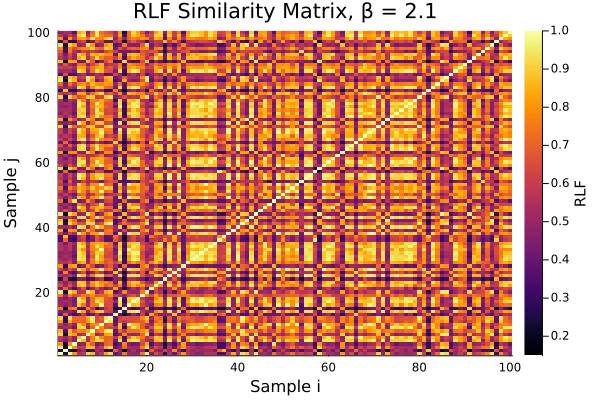

In [137]:
heatmap(similarity_matrix)
title!("RLF Similarity Matrix, β = 2.1", colorbar_title="RLF")
xlabel!("Sample i")
ylabel!("Sample j")

In [105]:
using MultivariateStats

In [138]:
mds = fit(MDS, similarity_matrix; distances=true, maxoutdim=2)

Classical MDS(indim = NaN, outdim = 2)

In [139]:
mds_embeddings = predict(mds);

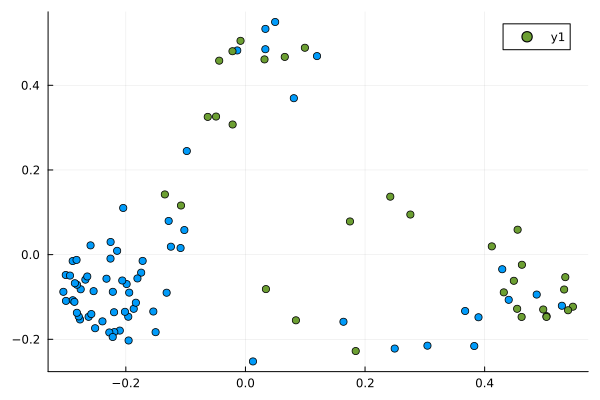

In [140]:
scatter(mds_embeddings[1, :], mds_embeddings[2,:], c=y_train[:,1])